In [1]:
import os
import os.path
import pickle

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
NOTE = '全特徴量を使用したSVM. class_weight を指定。Cは10.0'

N = 5
CV = f'Stratified-Kfold(K={N})'

notebook_name = '010_SVM_balanced_C10'
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1
CATEGORICAL_FEATURES =  [
        'batterID', 'pitcherID', 'Match',
        'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher',
        'isBottom', 'batterTeam', 'pitcherTeam'
    ]

010_submission.csv 010_SVM_balanced_C10


In [3]:
def get_estimator(categorical_features, discrete_features):
    discrete_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('discrete', discrete_transformer, discrete_features),
            ('categorical', 'passthrough', categorical_features),
        ]
    )
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('estimator', SVC(C=10.0, random_state=SEED, class_weight='balanced'))
        ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
for c in CATEGORICAL_FEATURES:
    assert(train[c].isin(test[c]).sum() == train.shape[0])
    assert(test[c].isin(train[c]).sum() == test.shape[0])

train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)

assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

In [6]:
categorical_features = []
for c in CATEGORICAL_FEATURES:
    categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features

['batterID_0',
 'batterID_2',
 'batterID_5',
 'batterID_9',
 'batterID_11',
 'batterID_12',
 'batterID_15',
 'batterID_18',
 'batterID_19',
 'batterID_21',
 'batterID_22',
 'batterID_26',
 'batterID_27',
 'batterID_28',
 'batterID_29',
 'batterID_31',
 'batterID_34',
 'batterID_36',
 'batterID_37',
 'batterID_39',
 'batterID_42',
 'batterID_45',
 'batterID_47',
 'batterID_50',
 'batterID_55',
 'batterID_56',
 'batterID_58',
 'batterID_60',
 'batterID_67',
 'batterID_70',
 'batterID_72',
 'batterID_73',
 'batterID_75',
 'batterID_80',
 'batterID_82',
 'batterID_84',
 'batterID_85',
 'batterID_87',
 'batterID_89',
 'batterID_91',
 'batterID_98',
 'batterID_102',
 'batterID_103',
 'batterID_105',
 'batterID_106',
 'batterID_111',
 'batterID_112',
 'batterID_114',
 'batterID_117',
 'batterID_118',
 'batterID_120',
 'batterID_121',
 'batterID_125',
 'batterID_127',
 'batterID_128',
 'batterID_130',
 'batterID_132',
 'batterID_134',
 'batterID_135',
 'batterID_137',
 'batterID_138',
 'batter

In [7]:
features = [c for c in train.columns if c not in ('id', 'y')]
assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
discrete_features = [f for f in features if f not in categorical_features]
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'b1',
 'b2',
 'b3',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabe

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )
    clf = get_estimator(categorical_features, discrete_features)
    clf.fit(X_train, y_train)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



**********Confusion matrix for train set (Fold 1)**********
[[2974  700  833  169  206  101    6   77]
 [ 404 2452  574   83  132   54    4   43]
 [ 198  158 1665  174  124   49    1   24]
 [   0    0   34 1675    0    0    0    0]
 [   0    0    0    0  540    0    0    0]
 [   0    0    0    0    0  150    0    0]
 [   0    0    0    0    0    0    8    0]
 [   0    0    0    0    0    0    0   96]]

**********Confusion matrix for validation set (Fold 1)**********
[[522 261 294  95  54  19   5  17]
 [280 271 238  93  30  15   2   7]
 [166 137 176  76  30   8   0   6]
 [ 95  78  84 167   2   1   0   0]
 [ 31  27  26  46   5   0   0   0]
 [  9   9   4  14   1   0   0   0]
 [  0   2   1   0   0   0   0   0]
 [  5   5   6   8   0   0   0   0]]

**********Confusion matrix for train set (Fold 2)**********
[[2992  675  852  169  206   96    8   68]
 [ 409 2404  626   83  118   61    6   39]
 [ 194  166 1670  172  122   45    1   23]
 [   0    0   34 1675    0    0    0    0]
 [   0    0    

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.663369,0.175991
std,0.003290,0.007212
min,0.658500,0.166744
25%,0.662479,0.173223
50%,0.663069,0.174963
75%,0.665970,0.178717
max,0.666825,0.186307


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,0,0,1
1,1,1,2,0,1
2,2,0,0,0,1
3,3,2,4,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17126,9690,0,2,0,5
17129,9693,1,2,0,5
17130,16833,1,1,0,5
17133,9762,1,2,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,1.712791,5.265871,5.220474,7.294397,5.255789,1.788847,-0.291924,1.787901,27446,1
1,4.243000,5.268355,6.263089,7.285199,2.912567,0.731694,-0.293977,1.726844,113,1
2,6.306595,7.309724,5.295705,3.733713,2.706858,0.705900,-0.294699,1.713917,4479,1
3,6.305995,7.308313,5.296156,3.744652,2.708561,0.705387,-0.294790,1.714330,29080,1
4,7.303481,5.266431,6.273915,4.178731,2.768042,1.736316,-0.294824,0.713062,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,2.751753,6.300822,3.915833,7.308282,5.249004,1.817600,-0.298194,0.693202,24272,5
33804,1.690362,1.691376,2.692447,7.322260,6.309893,5.273058,-0.294691,2.788374,29106,5
33805,0.687819,1.689997,2.689905,7.322968,6.310157,5.280674,-0.294807,3.848878,20679,5
33806,5.289237,1.694859,2.695912,7.316921,6.293296,4.070769,-0.295325,0.727571,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,27.452092,36.548861,30.475375,19.466101,13.651323,8.674054,-1.497627,3.484369
1,1,34.509693,33.521638,26.440869,19.062291,12.541753,9.661744,-1.486036,3.579862
2,2,3.453588,9.644011,13.700980,36.572934,31.509530,21.687067,-1.460753,23.515574
3,3,25.305572,26.293025,15.190002,36.482593,26.278966,8.754889,-1.486283,3.555984
4,4,31.535721,36.551106,26.389648,18.699058,13.579919,8.594760,-1.471667,3.523767
...,...,...,...,...,...,...,...,...,...
33803,33803,36.550032,30.110331,27.203530,15.977377,17.237384,6.701134,-1.486411,5.718463
33804,33804,27.415697,30.444974,18.856510,36.501272,13.976886,8.711600,-1.498811,3.619421
33805,33805,31.434164,26.343902,15.702060,36.434226,13.513468,3.642680,-1.470985,13.887500
33806,33806,8.530716,17.071705,22.039039,36.510515,29.409621,26.225980,-1.469676,3.536755


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,0
2,2,3
3,3,3
4,4,1
...,...,...
33803,33803,0
33804,33804,3
33805,33805,3
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.252662
1    0.258252
2    0.008193
3    0.471279
4    0.009347
5    0.000148
7    0.000118
Name: y, dtype: float64

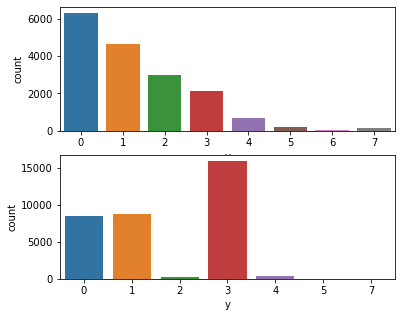

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.6633686076568889, 0.17599072106066246)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"010_submission.csv","Stratified-Kfold(K=5)","0.663369","0.175991","","全特徴量を使用したSVM. class_weight を指定。Cは10.0"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()